Modeling siltuximab in the absorption and delivery components of ADME PK analysis

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [8]:
# Updated PK parameters for siltuximab
k_ABS = 0.01  # Absorption rate constant [1/hour] (slow for subcutaneous mAbs)
k_CP = 0.02   # Rate constant from central to peripheral compartment [1/hour]
k_PC = 0.01   # Rate constant from peripheral to central compartment [1/hour]
k_Celim = 0.001  # Elimination rate constant [1/hour] (long half-life ~10 days)
k_CT = 0.005  # Rate constant for tumor homing [1/hour]
k_TC = 0.001  # Rate constant for leaving the tumor compartment [1/hour]
k_CL = 0.002  # Rate constant for accumulation in the liver [1/hour]
k_TMEelim = 0.0005  # TME effects reducing persistence in the tumor [1/hour]

V_CENTRAL = 3.0  # Volume of central compartment [Liters] (plasma volume for mAbs)
V_TUMOR = 0.1    # Volume of tumor compartment [Liters]
dose = 300       # Initial dose [mg] (typical dose for siltuximab)
MW = 145000      # Molecular weight of siltuximab [g/mol]
AVOGADRO = 6.022e23  # Avogadro's number [molecules/mol]

# Convert dose to molar units (moles)
dose_moles = dose / MW  # [moles]
dose_molecules = dose_moles * AVOGADRO  # [molecules]

In [9]:
def pk_model_tmdd(y, t, k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim):
    # y = [Dosing, Central, Peripheral, Tumor, Liver]
    dAdt = -k_ABS * y[0]  # Dosing compartment
    dCdt = (k_ABS * y[0] / V_CENTRAL) - (k_CP + k_CT + k_CL + k_Celim) * y[1] \
           + k_PC * y[2] + k_TC * y[3]  # Central compartment
    dPdt = k_CP * y[1] - k_PC * y[2]  # Peripheral compartment
    dTdt = k_CT * y[1] - (k_TC + k_TMEelim) * y[3]  # Tumor compartment
    dLiverdt = k_CL * y[1]  # Liver compartment
    return [dAdt, dCdt, dPdt, dTdt, dLiverdt]

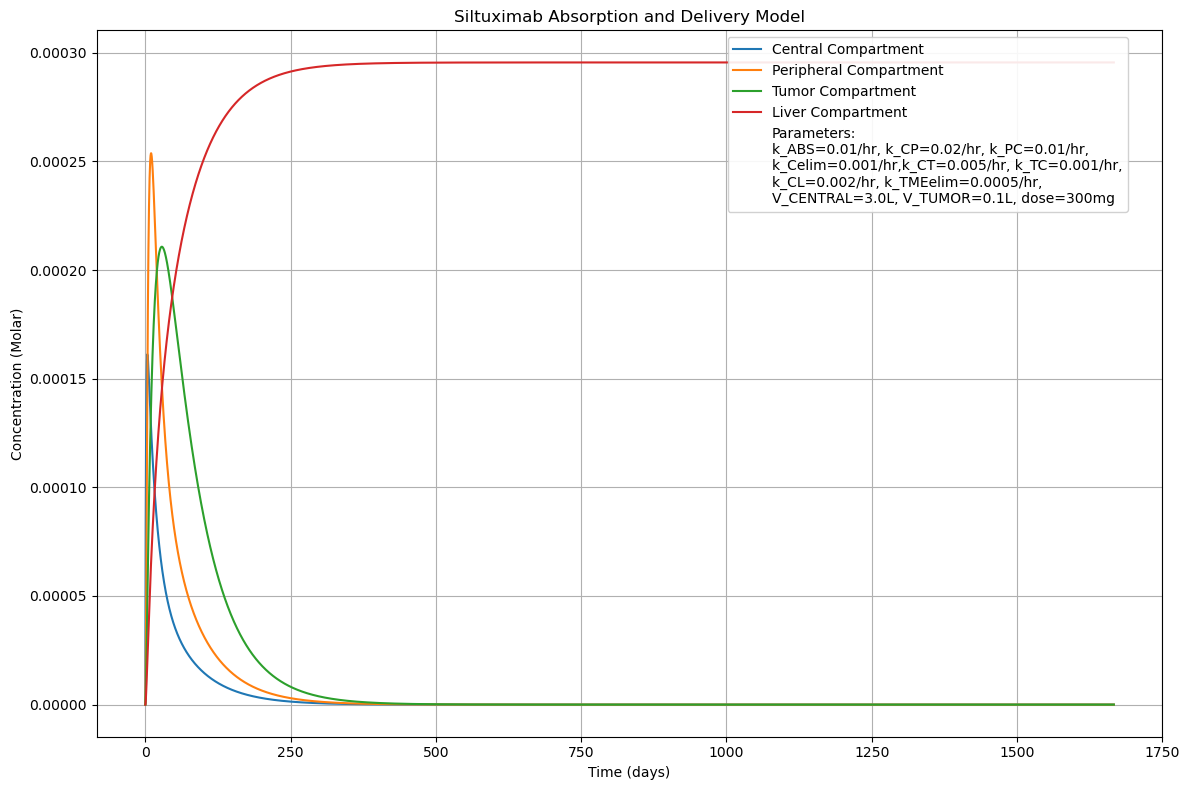

In [10]:
t = np.linspace(0, 40000, 5000)  # Simulate over 48 hours with fine resolution
# Initial conditions: [Dosing, Central, Peripheral, Tumor, Liver]
y0_tmdd = [dose_moles, 0, 0, 0, 0]  # Initial conditions

# Solve ODE with TMDD
solution_tmdd = odeint(pk_model_tmdd, y0_tmdd, t,
                       args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim),
                       atol=1e-12, rtol=1e-9)

# Plot results
# plt.figure(figsize=(12, 8))
# plt.plot(t, solution_tmdd[:, 1], label='Central Compartment')
# plt.plot(t, solution_tmdd[:, 2], label='Peripheral Compartment')
# plt.plot(t, solution_tmdd[:, 3], label='Tumor Compartment')
# plt.plot(t, solution_tmdd[:, 4], label='Liver Compartment')
# plt.xlabel('Time (hours)')
# plt.ylabel('Concentration')
# plt.title('Siltuximab PK Model with TMDD')
# plt.legend()
# plt.grid(True)
# plt.show()

# PLOT IN DAYS
t_days = t / 24  # Convert time from hours to days

# Add parameters to the legend
parameters_text = (
    f"k_ABS={k_ABS}/hr, k_CP={k_CP}/hr, k_PC={k_PC}/hr,\n" 
    f"k_Celim={k_Celim}/hr,k_CT={k_CT}/hr, k_TC={k_TC}/hr,\n"
    f"k_CL={k_CL}/hr, k_TMEelim={k_TMEelim}/hr,\n"
    f"V_CENTRAL={V_CENTRAL}L, V_TUMOR={V_TUMOR}L, dose={dose}mg"
)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(t_days, solution_tmdd[:, 1], label='Central Compartment')
plt.plot(t_days, solution_tmdd[:, 2], label='Peripheral Compartment')
plt.plot(t_days, solution_tmdd[:, 3], label='Tumor Compartment')
plt.plot(t_days, solution_tmdd[:, 4], label='Liver Compartment')
plt.plot([], [], ' ', label=f"Parameters:\n{parameters_text}")

plt.xlabel('Time (days)')  # Updated label
plt.ylabel('Concentration (Molar)')
plt.title('Siltuximab Absorption and Delivery Model')
# plt.legend()
# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.grid(True)
plt.tight_layout()

plt.show()

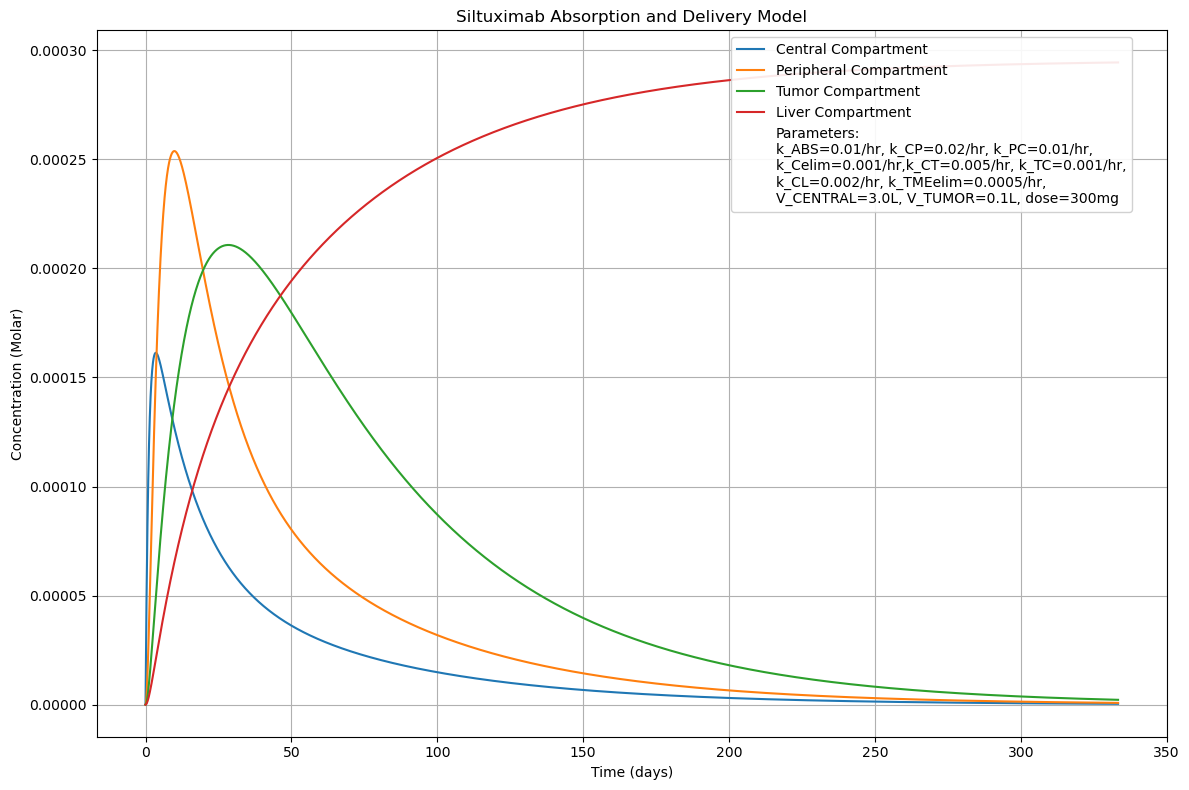

In [11]:
t = np.linspace(0, 8000, 5000)  # Simulate over 48 hours with fine resolution
# Initial conditions: [Dosing, Central, Peripheral, Tumor, Liver]
y0_tmdd = [dose_moles, 0, 0, 0, 0]  # Initial conditions

# Solve ODE with TMDD
solution_tmdd = odeint(pk_model_tmdd, y0_tmdd, t,
                       args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim),
                       atol=1e-12, rtol=1e-9)

# Plot results
# plt.figure(figsize=(12, 8))
# plt.plot(t, solution_tmdd[:, 1], label='Central Compartment')
# plt.plot(t, solution_tmdd[:, 2], label='Peripheral Compartment')
# plt.plot(t, solution_tmdd[:, 3], label='Tumor Compartment')
# plt.plot(t, solution_tmdd[:, 4], label='Liver Compartment')
# plt.xlabel('Time (hours)')
# plt.ylabel('Concentration')
# plt.title('Siltuximab PK Model with TMDD')
# plt.legend()
# plt.grid(True)
# plt.show()

# PLOT IN DAYS
t_days = t / 24  # Convert time from hours to days

# Add parameters to the legend
parameters_text = (
    f"k_ABS={k_ABS}/hr, k_CP={k_CP}/hr, k_PC={k_PC}/hr,\n" 
    f"k_Celim={k_Celim}/hr,k_CT={k_CT}/hr, k_TC={k_TC}/hr,\n"
    f"k_CL={k_CL}/hr, k_TMEelim={k_TMEelim}/hr,\n"
    f"V_CENTRAL={V_CENTRAL}L, V_TUMOR={V_TUMOR}L, dose={dose}mg"
)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(t_days, solution_tmdd[:, 1], label='Central Compartment')
plt.plot(t_days, solution_tmdd[:, 2], label='Peripheral Compartment')
plt.plot(t_days, solution_tmdd[:, 3], label='Tumor Compartment')
plt.plot(t_days, solution_tmdd[:, 4], label='Liver Compartment')
plt.plot([], [], ' ', label=f"Parameters:\n{parameters_text}")

plt.xlabel('Time (days)')  # Updated label
plt.ylabel('Concentration (Molar)')
plt.title('Siltuximab Absorption and Delivery Model')
# plt.legend()
# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.grid(True)
plt.tight_layout()

plt.show()

In [7]:
max_tumor_index = np.argmax(solution_tmdd[:,3])
time_of_max_tumor = t[max_tumor_index] # in hours
max_tumor_concentration = solution_tmdd[max_tumor_index, 3]

print(f"Time of Maximum Tumor Concentration: {time_of_max_tumor:.2f} hours")
print(f"Time of Maximum Tumor Concentration: {time_of_max_tumor/24:.2f} days")

print(f"Maximum Tumor Concentration: {max_tumor_concentration:.2e} Molar")

Time of Maximum Tumor Concentration: 681.74 hours
Time of Maximum Tumor Concentration: 28.41 days
Maximum Tumor Concentration: 4.22e-04 Molar
